In [1]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2021-01-28 14:20:28--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz’

Software_5.json.gz  100%[===================>]   5.09M  21.3MB/s    in 0.2s    

2021-01-28 14:20:28 (21.3 MB/s) - ‘Software_5.json.gz’ saved [5339013/5339013]



In [2]:
import os
import json
import gzip
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn
from urllib.request import urlopen
import tensorflow
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
data = []
with gzip.open('Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

#print(len(data)) -->12805
train_data = data[:10244]
train_df = pd.DataFrame.from_dict(train_data)

#train_df.describe()

train_df.drop(columns = ['vote', 'image','verified','reviewerID','unixReviewTime','style','reviewerName','reviewText','reviewTime'],axis=1,inplace=True)
train_df['summary'] = train_df['summary'].astype(str)
train_df.head()

,overall,asin,summary
0,4.0,0321719816,A solid overview of Dreamweaver CS5
1,4.0,0321719816,A good value
2,5.0,0321719816,This is excellent software for those who want ...
3,5.0,0321719816,A Fantastic Overview of Dream Weaver and Web D...
4,5.0,0321719816,Excellent Tutorials!


In [4]:
test_data = data[10244:]
test_df = pd.DataFrame.from_dict(test_data)

test_df.drop(columns=['vote', 'image','verified','reviewerID','unixReviewTime','style','reviewerName','reviewText','reviewTime'],axis=1,inplace=True)
test_df['summary'] = test_df['summary'].astype(str)
#test_df.head()

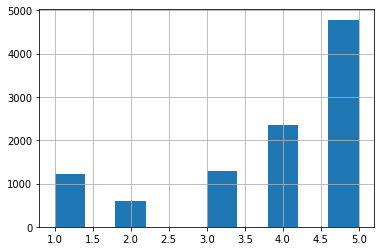

In [10]:
train = train_df[['summary', 'overall']] #train and test frequencies remain proportional still biased to 4 and 5 rating
train['overall'].hist()

In [11]:
#text pre-processing

from nltk.corpus import stopwords    
from textblob import Word

stoplist = set(stopwords.words('english'))

# For frequent words removal
freq = pd.Series(' '.join(train_df['summary']).split()).value_counts()[:10]
freq = list(freq.index)


# For rare words removal 
freq1 = pd.Series(' '.join(train_df['summary']).split()).value_counts()[-10:]
freq1=list(freq1.index)


def cleaning_text(df):
    df['summary'] = df['summary'].str.lower().str.replace('[^\w\s]','')                                                               # Punctuation Removal
    df['summary'] = df['summary'].apply( lambda x: ' '.join([w for w in str(x).split() if w not in stoplist]) )                       # Removing stopwords
    df['summary']= df['summary'].apply( lambda x:' '.join(x for x in x.split(" ") if not x.isdigit()) )                               # Numbers Removal
    df['summary'] = df['summary'].apply(lambda x: ' '.join(x for x in x.split(" ") if x not in freq))                                 # Frequent words removal
    df['summary'] = df['summary'].apply(lambda x: " ".join(x for x in x.split(" ") if x not in freq1))                                # Rare words removal
    df['summary'] = df['summary'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))                           # Lemmatization
    

cleaning_text(train_df)
cleaning_text(test_df)
train_df.head()
# Pre-processing of both the training and testing datasets is done . 

,overall,asin,summary
0,4.0,0321719816,solid overview dreamweaver cs5
1,4.0,0321719816,value
2,5.0,0321719816,excellent want crash refresher course wannabe ...
3,5.0,0321719816,fantastic overview dream weaver web design gen...
4,5.0,0321719816,excellent tutorial


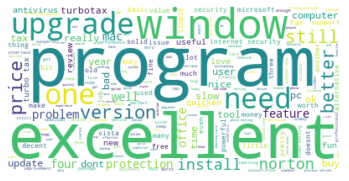

In [12]:
wordcloud = WordCloud(background_color='white').generate(' '.join(train_df['summary']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X = train_df['summary']
y = train_df['overall']
cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)
mnb = KNeighborsClassifier()
mnb.fit(X_train, y_train)
y_test_pred = mnb.predict(X_test)
print(classification_report(y_test,y_test_pred))



              precision    recall  f1-score   support

         1.0       0.23      0.54      0.32      1081
         2.0       0.12      0.14      0.13       540
         3.0       0.53      0.10      0.16      1166
         4.0       0.43      0.33      0.37      2104
         5.0       0.61      0.60      0.60      4329

    accuracy                           0.44      9220
   macro avg       0.38      0.34      0.32      9220
weighted avg       0.49      0.44      0.44      9220

